# ABM - OT comparison

Let's import `ot` which is POT (Python Optimal Transport) and the local ABM to compare against, here called `sx`.

In [15]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pytest
import ot
import ot.plot
import pyflamegpu

from sx import make_simulation, C
import util


def plot_cost(M, extra=""):
    plt.figure(2)
    plt.imshow(M, interpolation="nearest")
    plt.title(f"Cost matrix M{extra}")
    plt.show()


def plot_ot(xs, xt, G, what):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)
    plt.imshow(G, interpolation="nearest")
    plt.title(f"OT matrix: {what}")
    plt.subplot(1, 2, 2)
    ot.plot.plot2D_samples_mat(xs, xt, G, color=[0.5, 0.5, 1])
    plt.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples")
    plt.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples")
    plt.legend(loc=0)
    plt.title(f"OT matrix: {what} with samples")
    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()


# scaling x,y from [0, 1] to a range that can be reasonably displayed in integer coordinates, and that is not too large for agents to walk through
SCALE = 5


def generate_distributions(s=50, t=50):
    mu_s = np.array([4, 4])
    cov_s = np.array([[1, 0], [0, 1]])
    mu_t = np.array([8, 8])
    cov_t = np.array([[1, -0.8], [-0.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(s, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(t, mu_t, cov_t)
    xs[xs < 0] *= -1
    xt[xt < 0] *= -1
    xs *= SCALE
    xt *= SCALE
    return np.round(xs).astype("int"), np.round(xt).astype("int")

## OT Solution

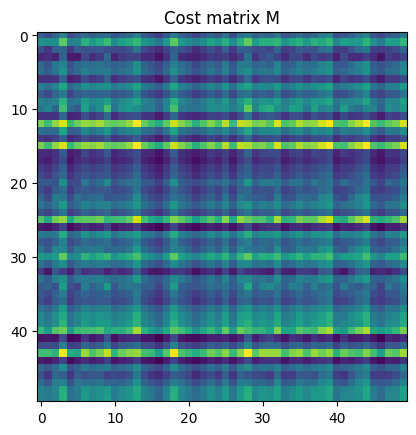

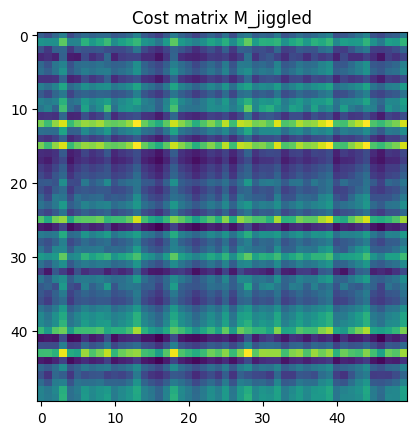

sinkhorn:
[[1.48694505e-07 7.81422924e-05 5.66770761e-26 ... 3.15413450e-04
  7.01368838e-04 5.08374468e-09]
 [8.25065187e-04 2.79460848e-14 7.00693417e-05 ... 6.31624381e-20
  8.04577836e-09 3.95567499e-18]
 [5.84732880e-18 2.79701705e-08 1.01586595e-44 ... 6.82405771e-05
  4.11948295e-10 7.28121978e-14]
 ...
 [9.02452374e-19 2.93931402e-05 1.50288449e-45 ... 2.95834896e-03
  6.35801833e-11 1.71076000e-18]
 [1.26910917e-04 1.05383167e-05 1.98959788e-15 ... 1.44721993e-08
  9.13344294e-05 1.00361895e-13]
 [1.97104702e-03 1.07694014e-08 9.48764661e-11 ... 2.95561877e-12
  2.56911691e-05 1.39356647e-13]]


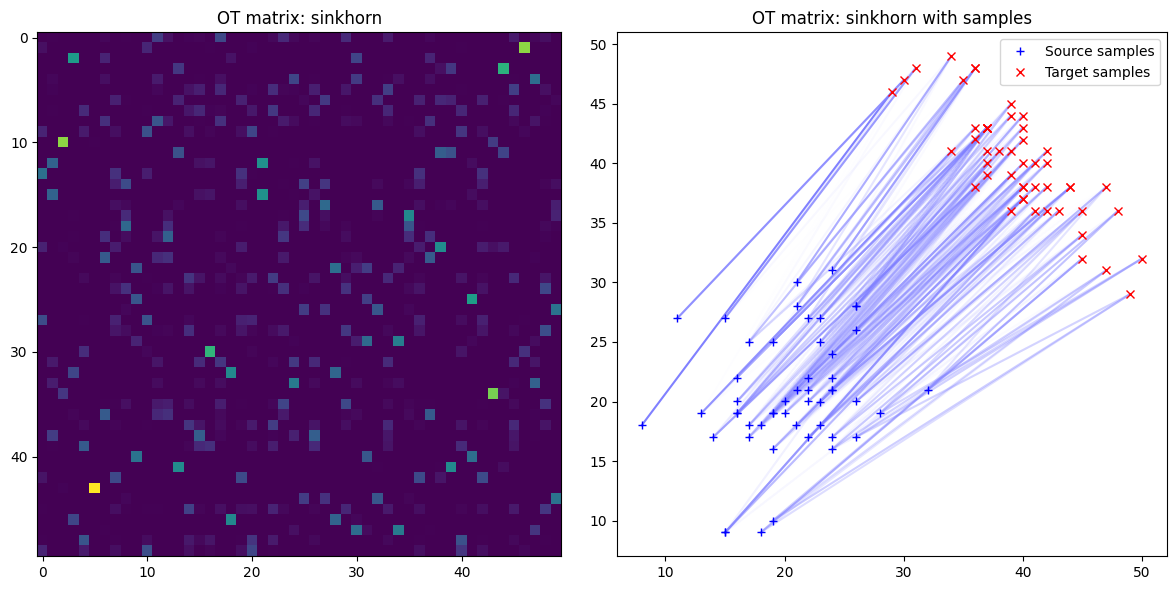

EMD:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


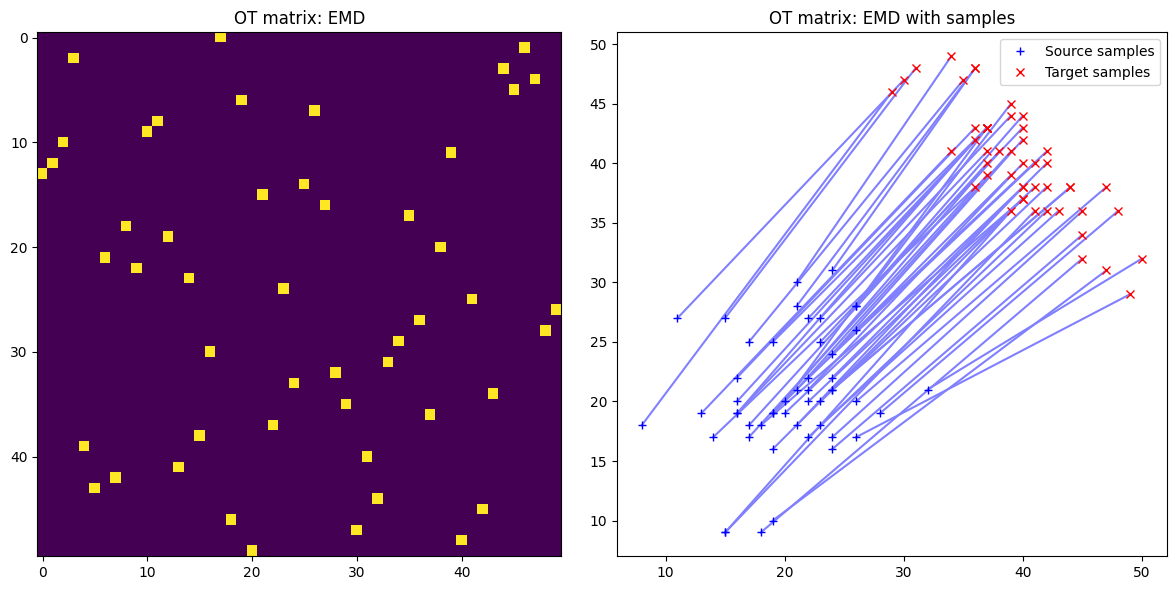

In [16]:
# pos_source, pos_target = np.array([[5, 0], [0, 5]]), np.array([[13, 16], [16, 13]])
pos_source, pos_target = generate_distributions()

# setup cost/loss matrix
M_loss = ot.dist(pos_source, pos_target)
jiggle = lambda x: (x + 0.01 * np.random.rand(*x.shape)) / SCALE
pos_source_j, pos_target_j = jiggle(pos_source), jiggle(pos_target)
M_loss_jiggled = ot.dist(pos_source_j, pos_target_j)
plot_cost(M_loss)
plot_cost(M_loss_jiggled, extra="_jiggled")
# initialize
n, m = len(pos_source), len(pos_target)

# sinkhorn: needs x,y \in [0, 1] and requires jiggled input for convergence
# (equal distances that are common with integer locations on a small scale hinder convergence)
a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples
regularization = 1e-1
exp_shinkhorn = ot.sinkhorn(a, b, M_loss_jiggled, regularization)
print(f"sinkhorn:\n{exp_shinkhorn}")
plot_ot(pos_source_j * SCALE, pos_target_j * SCALE, exp_shinkhorn, "sinkhorn")

# EMD -- Earth Movers Distance - works fine
a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples
exp = ot.emd(a, b, M_loss)
print(f"EMD:\n{exp}")
plot_ot(pos_source, pos_target, exp, "EMD")

## ABM solution

[99] humans=100
[199] humans=100
[299] humans=100
[399] humans=100
[499] humans=100
[599] humans=100
[699] humans=100
[799] humans=100
[899] humans=100
[999] humans=100


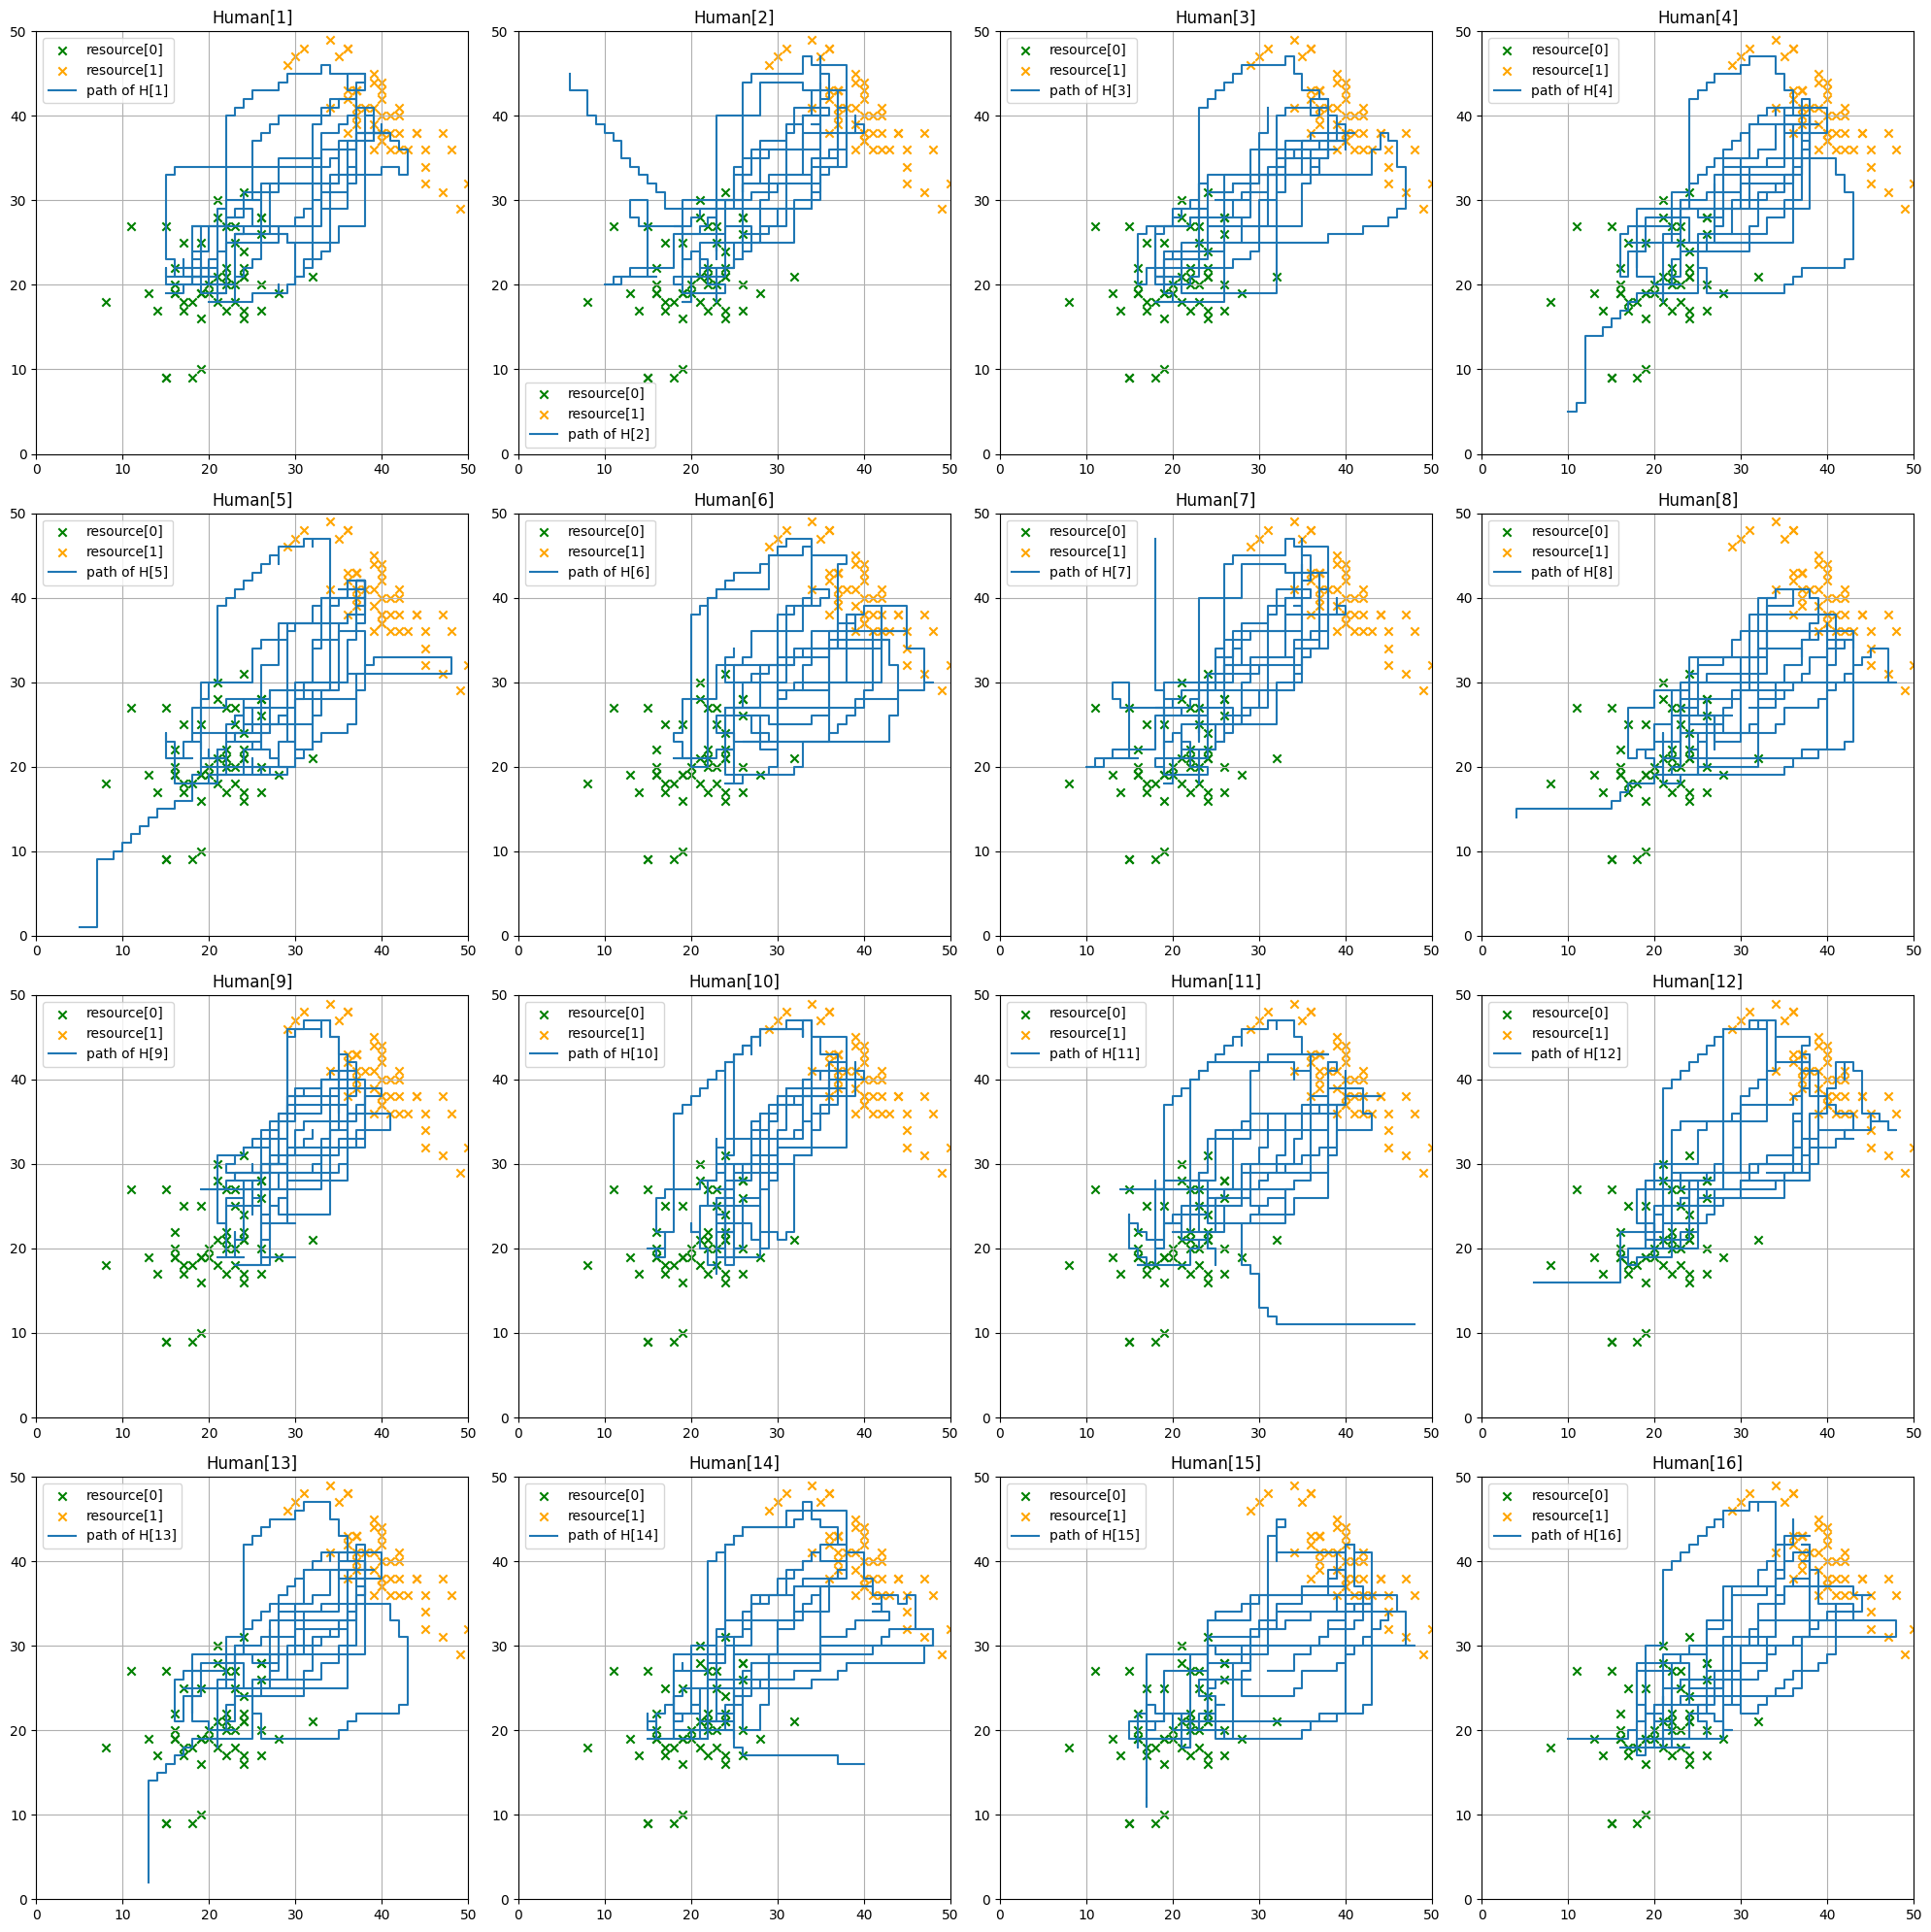

got:
 [[0.         0.00023866 0.         ... 0.00095465 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00119332 0.00023866 0.         ... 0.00119332 0.         0.00453461]
 ...
 [0.         0.00047733 0.         ... 0.         0.         0.        ]
 [0.00119332 0.         0.         ... 0.         0.00238663 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
exp:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


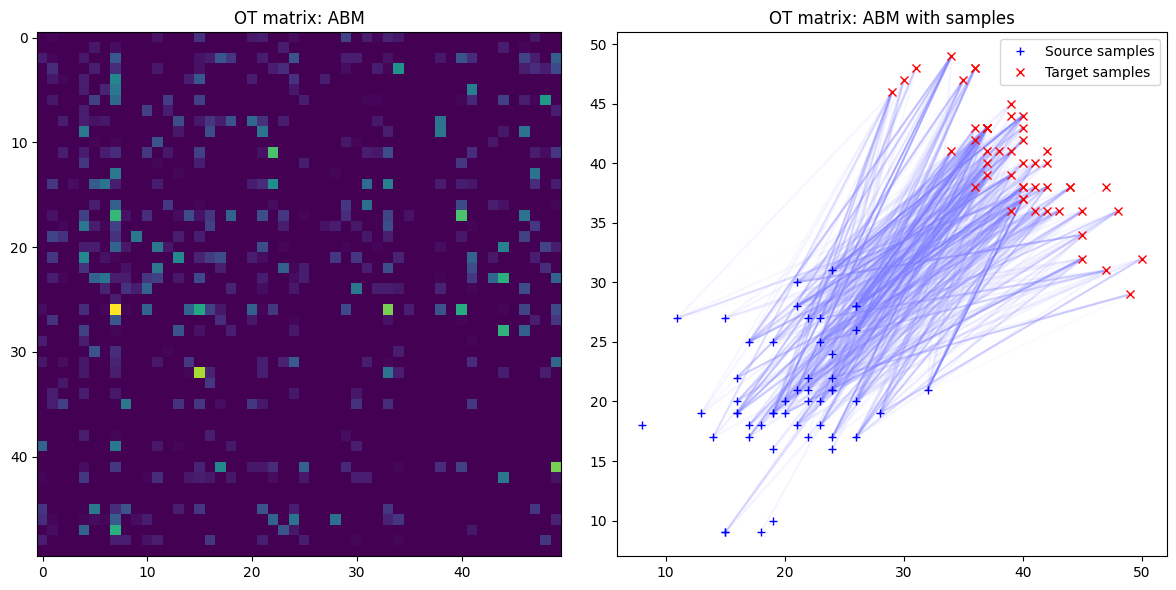

In [20]:
seed = 4
random.seed(seed)
grid_size = int(np.max([pos_source, pos_target]))
n_humans = 100
steps = 1000


def random_location(grid_size):
    return random.randint(0, grid_size), random.randint(0, grid_size)


C.RESOURCE_RESTORATION_TICKS = 50
C.HUNGER_STARVED_TO_DEATH = 1000
C.N_HUMANS_CROWDED = 200
model, simulation, ctx = make_simulation(grid_size=grid_size)
simulation.SimulationConfig().random_seed = seed
resources = pyflamegpu.AgentVector(ctx.resource, len(pos_source) + len(pos_target))
for i, p in enumerate(pos_source):
    resources[i].setVariableInt("x", int(p[0]))
    resources[i].setVariableInt("y", int(p[1]))
    resources[i].setVariableInt("type", 0)
for i, p in enumerate(pos_target):
    resources[i + len(pos_source)].setVariableInt("x", int(p[0]))
    resources[i + len(pos_source)].setVariableInt("y", int(p[1]))
    resources[i + len(pos_source)].setVariableInt("type", 1)
humans = pyflamegpu.AgentVector(ctx.human, n_humans)
for human in humans:
    human.setVariableInt("x", random.randint(0, grid_size))
    human.setVariableInt("y", random.randint(0, grid_size))
    human.setVariableArrayInt("resources", (2, 2))
    human.setVariableFloat("actionpotential", C.AP_DEFAULT)
for av in [resources, humans]:
    simulation.setPopulationData(av)
paths = []
collected_resources = []
for step in range(steps):
    simulation.step()
    simulation.getPopulationData(humans)
    if len(humans) == 0:
        print("[WARNING] All humans are dead. Simulation stops early.")
        break
    if step % (steps / 10) == (steps / 10) - 1:
        print(f"[{step}] humans={len(humans)}")
    for human in humans:
        id = human.getID()
        x, y = human.getVariableInt("x"), human.getVariableInt("y")
        paths.append([id, x, y])
        loc = human.getVariableArrayInt("ana_last_resource_location")
        if loc != (-1, -1):
            collected_resources.append([id, *loc])
# print(collected_resources)
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()
paths = np.array(paths)
for i, id in enumerate(set(paths[:, 0])):
    if i == 16:
        break  # only size for 16 humans in this grid
    path = paths[paths[:, 0] == id][:, 1:3]
    x = path[:, 0]
    y = path[:, 1]
    ax = axs[i]
    ax.scatter(
        pos_source[:, 0],
        pos_source[:, 1],
        color="green",
        marker="x",
        label="resource[0]",
    )
    ax.scatter(
        pos_target[:, 0],
        pos_target[:, 1],
        color="orange",
        marker="x",
        label="resource[1]",
    )
    ax.plot(x, y, linestyle="-", marker="", label=f"path of H[{id}]")
    ax.set_title(f"Human[{id}]")
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

got = util.collected_resource_list_to_cost_matrix(
    collected_resources, pos_source, pos_target
)
print("got:\n", got)
print("exp:\n", exp)

plot_ot(pos_source, pos_target, got, "ABM")

## Comparison

To compare the two OT-matrices (linear pdf functions) the [Kolmogoriv-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test) is used.

In [27]:
import scipy

s = got.shape[0] * got.shape[1]
rvs, cfg = got.reshape((s,)), exp.reshape((s,))
scipy.stats.kstest(rvs, cfg)

KstestResult(statistic=0.1568, pvalue=3.1753302702365873e-27, statistic_location=0.0, statistic_sign=-1)

In [34]:
# we must filter zeroes out, when using chi^2, but that gives us a wrong result,
# since there might be non-zero values in the other distribution at that index
m = (rvs != 0) & (cfg != 0)
scipy.stats.chisquare(rvs[m] / np.sum(rvs[m]), cfg[m] / np.sum(cfg[m]))

Power_divergenceResult(statistic=1.291666666666667, pvalue=0.9357868325862629)

In [29]:
tv_distance = np.sum(np.abs(rvs - cfg))
print("Total Variation Distance:", tv_distance)

Total Variation Distance: 1.9885441527446301


In [31]:
js_divergence = scipy.spatial.distance.jensenshannon(rvs, cfg)
print("Jensen-Shannon Divergence:", js_divergence)

Jensen-Shannon Divergence: 0.8263244068146334
